In [1]:
ENV["JULIA_PKG_USE_CLI_GIT"] = "true"
cd("/leonardo_work/Sis25_degironc_0/apol/aceconverge2025/acejulia")
pwd()

import Pkg
Pkg.activate(".")
Pkg.add(Pkg.PackageSpec(;name="ACEpotentials", version="0.6.11"))

using ACEpotentials

  Activating project at `/leonardo_work/Sis25_degironc_0/apol/aceconverge2025/acejulia`
   Resolving package versions...
  No Changes to `/leonardo_work/Sis25_degironc_0/apol/aceconverge2025/acejulia/Project.toml`
  No Changes to `/leonardo_work/Sis25_degironc_0/apol/aceconverge2025/acejulia/Manifest.toml`


In [ ]:
# testing 
using ACE1
D = load_dict("/leonardo_work/Sis25_degironc_0/apol/aceconverge2025/acejulia/Tr124_dim_kappa1_pot.json")

Dict{String, Any} with 2 entries:
  "Versions" => Dict{String, Any}("JuLIP"=>Dict{String, Any}("major"=>0, "prere…
  "IP"       => Dict{String, Any}("components"=>Any[Dict{String, Any}("E0"=>Dic…

In [3]:
IP = read_dict(D["IP"])

JuLIP.MLIPs.SumIP{AbstractCalculator}(AbstractCalculator[OneBody{Float64}(Dict(:C => -245.44385736)), PolyPairPot{Float64, ACE1.OrthPolys.TransformedPolys{Float64, ACE1.Transforms.Agnesi2Transform{Float64, Int64}, ACE1.OrthPolys.OrthPolyBasis{Float64}, PolyEnvelope{Float64}}, 1, 0}([60.82150888596024, -107.76630728966568, 128.99107446918865, -122.53761941275778, 114.52399175351684, -93.21677276107971, 68.63941707379006, -41.29809623508968, 18.542051584709743, -4.866236628908764], PolyPairBasis{ACE1.OrthPolys.TransformedPolys{Float64, ACE1.Transforms.Agnesi2Transform{Float64, Int64}, ACE1.OrthPolys.OrthPolyBasis{Float64}, PolyEnvelope{Float64}}, 1}(JuLIP.Potentials.SZList{1}(AtomicNumber[<6>]), ACE1.OrthPolys.TransformedPolys{Float64, ACE1.Transforms.Agnesi2Transform{Float64, Int64}, ACE1.OrthPolys.OrthPolyBasis{Float64}, PolyEnvelope{Float64}}[ACE1.OrthPolys.TransformedPolys{Float64, ACE1.Transforms.Agnesi2Transform{Float64, Int64}, ACE1.OrthPolys.OrthPolyBasis{Float64}, PolyEnvelope{F

In [6]:
@which save_dict

ACEbase.FIO

In [9]:
# dataset 
data_file = "/leonardo_work/Sis25_degironc_0/apol/Tr124_dim.xyz"
data = read_extxyz(data_file);

In [11]:
# basis construction with purification (pure = true) or otherwise
r0 = 1.5
basis = ACE1x.ace_basis(
    elements = [:C],
    order = 2,
    totaldegree = 10,
    rcut = 7.0,
    r0 = r0,
    pure = true
)
@show length(basis)

[ Info: Option `pure = true` overrides `pure2b=true`


length(basis) = 51


51

`Vref` is the reference/chemical potential of the system to be added in the end to the ACE potential. Can use one-body potential/reference atom energy for each specie. Usage of a one-body reference potential results in a **significantly** improved 2-body potential with a realistic dimer shape. 

In [12]:
Vref = OneBody(:C => -245.44385736)

# regression weights
# weights = Dict(
#     "FLD_TiAl" => Dict("E" => 60.0, "F" => 1.0, "V" => 1.0 ),
#     "TiAl_T5000" => Dict("E" => 5.0, "F" => 1.0, "V" => 1.0)
# )
weights = Dict(
    "shaiducarbon" => Dict("E" => 1.85, "F" => 1.0)
    
)

Dict{String, Dict{String, Float64}} with 1 entry:
  "shaiducarbon" => Dict("E"=>1.85, "F"=>1.0)

In [13]:
# Basis precomputation 
datakeys = (energy_key = "energy", force_key = "force")
train = [ACEpotentials.AtomsData(t; weights=weights, v_ref=Vref, datakeys...) for t in data]
A, Y, W = ACEfit.assemble(train, basis) # A, Y, W are needed for the solver. See equation below.
P = smoothness_prior(basis; p=4);

[ Info: Assembling linear problem.
[ Info:   - Creating feature matrix with size (854, 51).
[ Info:   - Beginning assembly with processor count:  1.
Progress: 100%|█████████████████████████████████████████| Time: 0:00:48
[ Info:   - Assembly completed.
[ Info: Assembling full weight vector.
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


In [14]:
# Potential 1
solver = ACEfit.LSQR(damp = 1e-2, atol = 1e-6, P = P) # damp = lambda 
results = ACEfit.solve(solver, W .* A, W .* Y) # W .* A is element-wise multiplication of W and A
pot_1 = JuLIP.MLIPs.SumIP(Vref, JuLIP.MLIPs.combine(basis, results["C"]))

damp  0.01
atol  1.0e-6
maxiter  100000
Converged

┌ Warning: Need to apply preconditioner in LSQR.
└ @ ACEfit ~/.julia/packages/ACEfit/IW8vD/src/solvers.jl:95


 after 18 iterations.
relative RMS error  0.017411714536787613


JuLIP.MLIPs.SumIP{Any}(Any[OneBody{Float64}(Dict(:C => -245.44385736)), PolyPairPot{Float64, ACE1.OrthPolys.TransformedPolys{Float64, ACE1.Transforms.Agnesi2Transform{Float64, Int64}, ACE1.OrthPolys.OrthPolyBasis{Float64}, PolyEnvelope{Float64}}, 1, 0}([60.82150888596024, -107.76630728966568, 128.99107446918865, -122.53761941275778, 114.52399175351684, -93.21677276107971, 68.63941707379006, -41.29809623508968, 18.542051584709743, -4.866236628908764], PolyPairBasis{ACE1.OrthPolys.TransformedPolys{Float64, ACE1.Transforms.Agnesi2Transform{Float64, Int64}, ACE1.OrthPolys.OrthPolyBasis{Float64}, PolyEnvelope{Float64}}, 1}(JuLIP.Potentials.SZList{1}(AtomicNumber[<6>]), ACE1.OrthPolys.TransformedPolys{Float64, ACE1.Transforms.Agnesi2Transform{Float64, Int64}, ACE1.OrthPolys.OrthPolyBasis{Float64}, PolyEnvelope{Float64}}[ACE1.OrthPolys.TransformedPolys{Float64, ACE1.Transforms.Agnesi2Transform{Float64, Int64}, ACE1.OrthPolys.OrthPolyBasis{Float64}, PolyEnvelope{Float64}}(ACE1.OrthPolys.OrthPo

In [15]:
# Potential 2 to highlight advantage of acebasis
weights["shaiducarbon"]["E"] = 500.0
W = ACEfit.assemble_weights(train)
solver = ACEfit.LSQR(damp = 1e-2, atol = 1e-6, P = P)
results = ACEfit.solve(solver, W .* A, W .* Y)
pot_2 = JuLIP.MLIPs.SumIP(Vref, JuLIP.MLIPs.combine(basis, results["C"]))

damp  0.01
atol  1.0e-6
maxiter  100000
Converged after 18 iterations.
relative RMS error  0.0056854398156393595


[ Info: Assembling full weight vector.
┌ Warning: Need to apply preconditioner in LSQR.
└ @ ACEfit ~/.julia/packages/ACEfit/IW8vD/src/solvers.jl:95


JuLIP.MLIPs.SumIP{Any}(Any[OneBody{Float64}(Dict(:C => -245.44385736)), PolyPairPot{Float64, ACE1.OrthPolys.TransformedPolys{Float64, ACE1.Transforms.Agnesi2Transform{Float64, Int64}, ACE1.OrthPolys.OrthPolyBasis{Float64}, PolyEnvelope{Float64}}, 1, 0}([9.56929033776388, -23.73847099226515, 31.86488251807065, -24.94701030245997, 25.92934690735256, -20.180142314604314, 15.583558325293476, -9.320807614255388, 4.524725230817843, -1.4746101217923413], PolyPairBasis{ACE1.OrthPolys.TransformedPolys{Float64, ACE1.Transforms.Agnesi2Transform{Float64, Int64}, ACE1.OrthPolys.OrthPolyBasis{Float64}, PolyEnvelope{Float64}}, 1}(JuLIP.Potentials.SZList{1}(AtomicNumber[<6>]), ACE1.OrthPolys.TransformedPolys{Float64, ACE1.Transforms.Agnesi2Transform{Float64, Int64}, ACE1.OrthPolys.OrthPolyBasis{Float64}, PolyEnvelope{Float64}}[ACE1.OrthPolys.TransformedPolys{Float64, ACE1.Transforms.Agnesi2Transform{Float64, Int64}, ACE1.OrthPolys.OrthPolyBasis{Float64}, PolyEnvelope{Float64}}(ACE1.OrthPolys.OrthPolyB

# Validation/testing

In [16]:
test_data_dir = "/leonardo_work/Sis25_degironc_0/apol/Val123_dim.xyz"
test_data = read_extxyz(test_data_dir);

In [17]:
test = [ACEpotentials.AtomsData(t; weights=weights, v_ref=Vref, datakeys...) for t in test_data]

@info("Test Error Tables")
@info("First Potential")
err1 = ACEpotentials.linear_errors(train, pot_1);

[ Info: Test Error Tables
[ Info: First Potential
[ Info: RMSE Table


┌──────────────┬─────────┬──────────┬─────────┐
│         Type │ E [meV] │ F [eV/A] │ V [meV] │
├──────────────┼─────────┼──────────┼─────────┤
│ shaiducarbon │ 165.288 │    1.470 │   0.000 │
├──────────────┼─────────┼──────────┼─────────┤
│          set │ 165.288 │    1.470 │   0.000 │
└──────────────┴─────────┴──────────┴─────────┘
┌──────────────┬─────────┬──────────┬─────────┐
│         Type │ E [meV] │ F [eV/A] │ V [meV] │
├──────────────┼─────────┼──────────┼─────────┤
│ shaiducarbon │ 139.360 │    1.109 │   0.000 │
├──────────────┼─────────┼──────────┼─────────┤
│          set │ 139.360 │    1.109 │   0.000 │
└──────────────┴─────────┴──────────┴─────────┘


[ Info: MAE Table


In [ ]:
err1["rmse"]["shaiducarbon"]["F"]

1.4698637181764689

In [28]:
err1["rmse"]

Dict{String, Any} with 2 entries:
  "set"          => Dict("V"=>0.0, "E"=>0.165288, "F"=>1.46986)
  "shaiducarbon" => Dict("V"=>0.0, "E"=>0.165288, "F"=>1.46986)

In [26]:
typeof(err1["rmse"])

Dict{String, Any}

In [ ]:
save_dict("err1.json",err1["rmse"])

In [31]:
qwer = load_dict("err1.json")
print(qwer,"\n", typeof(qwer))

Dict{String, Any}("set" => Dict{String, Any}("V" => 0.0, "E" => 0.165287944228281, "F" => 1.4698637181764689), "shaiducarbon" => Dict{String, Any}("V" => 0.0, "E" => 0.165287944228281, "F" => 1.4698637181764689))
Dict{String, Any}

In [18]:
@info("Second Potential:")
ACEpotentials.linear_errors(train, pot_2);

┌──────────────┬─────────┬──────────┬─────────┐
│         Type │ E [meV] │ F [eV/A] │ V [meV] │
├──────────────┼─────────┼──────────┼─────────┤
│ shaiducarbon │  66.950 │    2.744 │   0.000 │
├──────────────┼─────────┼──────────┼─────────┤
│          set │  66.950 │    2.744 │   0.000 │
└──────────────┴─────────┴──────────┴─────────┘
┌──────────────┬─────────┬──────────┬─────────┐
│         Type │ E [meV] │ F [eV/A] │ V [meV] │
├──────────────┼─────────┼──────────┼─────────┤
│ shaiducarbon │  50.192 │    1.064 │   0.000 │
├──────────────┼─────────┼──────────┼─────────┤
│          set │  50.192 │    1.064 │   0.000 │
└──────────────┴─────────┴──────────┴─────────┘


[ Info: Second Potential:
[ Info: RMSE Table
[ Info: MAE Table


# Dimers

In [19]:
using Plots, LaTeXStrings, DelimitedFiles

In [20]:
print(D)

Dict{String, Any}("Versions" => Dict{String, Any}("JuLIP" => Dict{String, Any}("major" => 0, "prerelease" => Any[], "build" => Any[], "patch" => 0, "minor" => 16), "ACEbase" => Dict{String, Any}("major" => 0, "prerelease" => Any[], "build" => Any[], "patch" => 4, "minor" => 4), "ACE1x" => Dict{String, Any}("major" => 0, "prerelease" => Any[], "build" => Any[], "patch" => 11, "minor" => 1), "ACE1" => Dict{String, Any}("major" => 0, "prerelease" => Any[], "build" => Any[], "patch" => 5, "minor" => 12), "ACEmd" => Dict{String, Any}("major" => 0, "prerelease" => Any[], "build" => Any[], "patch" => 19, "minor" => 1), "ACEpotentials" => Dict{String, Any}("major" => 0, "prerelease" => Any[], "build" => Any[], "patch" => 11, "minor" => 6), "ACEfit" => Dict{String, Any}("major" => 0, "prerelease" => Any[], "build" => Any[], "patch" => 5, "minor" => 2)), "IP" => Dict{String, Any}("components" => Any[Dict{String, Any}("E0" => Dict{String, Any}("C" => -245.44385736), "__id__" => "JuLIP_OneBody"), 

In [21]:
@which ACEpotentials.dimers

ACEpotentials

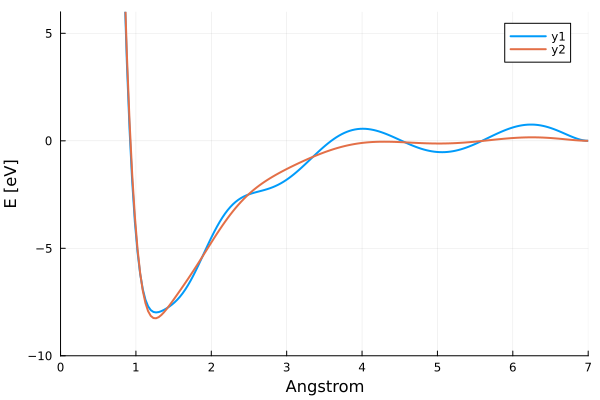

In [22]:
plt_dim = plot(
    legend = :topright, 
    xlabel = "Angstrom", ylabel = "E [eV]",
    xlims = (0, 7), ylims = (-10, 6))


D = ACEpotentials.dimers(pot_1, [:C,])
D2 = ACEpotentials.dimers(pot_2, [:C,])
plot!(plt_dim, D[(:C,:C)]..., lw=2)
plot!(plt_dim, D2[(:C,:C)]..., lw=2)
plt_dim

In [ ]:
@doc save_potential

```
save_potential( fname, potential::ACE1x.ACE1Model; save_version_numbers=true, meta=nothing)
```

Save ACE potentials. Prefix is either .json, .yml or .yace, which also determines file format.

# Kwargs

  * save*version*numbers=true  : If true save version information or relevant packages
  * `meta=nothing`             : Seve some metadata with the potential (needs to be `Dict{String, Any}`)


In [ ]:
@which save_potential

ACEpotentials

In [24]:
save_potential("/leonardo_work/Sis25_degironc_0/apol/aceconverge2025/acejulia/test_pot.json", pot_1)